In [89]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

In [90]:
dir = './p2_data'
image_list = os.listdir(dir)
# random.shuffle(image_list)
x_train = []
x_test = []
y_train =[]
y_test = []
p2i1idx = 0 #儲存person2image1的idx
count = 0  #計算person2image1的idx
for idx,img_name in enumerate(image_list):
    img_path = os.path.join(dir, img_name)
    if img_name.split('_')[1]=='10.png':
        face = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float64)
        face = face.flatten()
        x_test.append(face)
        y_test.append(img_name.split('_')[0])
    else:
        if (img_name.split('.')[0] == '2_1'):
          p2i1idx = count
        face = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float64)
        face = face.flatten()
        x_train.append(face)
        y_train.append(img_name.split('_')[0])
        count += 1

x_train = np.array(x_train).astype(np.float).T
x_test = np.array(x_test).astype(np.float).T
y_train = np.array(y_train).astype(np.int)
y_test = np.array(y_test).astype(np.int)
print('Training size: ',x_train.shape)
print('Testing size: ',x_test.shape)
print('y_train size:', y_train.shape)
print('y_test size:', y_test.shape)

Training size:  (2576, 360)
Testing size:  (2576, 40)
y_train size: (360,)
y_test size: (40,)


In [91]:
#計算平均值並把train_face & test_face扣掉平均值
mean = x_train.mean(axis=1) # 2576 * 360
for i in range(x_train.shape[1]):
  x_train[:,i] -= mean
for i in range(x_test.shape[1]):
  x_test[:,i] -= mean

In [92]:
# ref:https://stats.stackexchange.com/questions/202104/whats-the-physical-meaning-of-the-eigenvectors-of-the-gram-kernel-matrix
_,lamb, v = np.linalg.svd(x_train)
v = v.T # eigenvectors of the covariance matrix
u = np.dot(x_train,v)

In [93]:
# Normalize u to ||u||=1
norm = np.linalg.norm(u,axis=0)
u = u / norm

In [94]:
eigensortindex = np.argsort(-lamb)
print('dominant eigenfaces: ',eigensortindex[:4])

dominant eigenfaces:  [0 1 2 3]


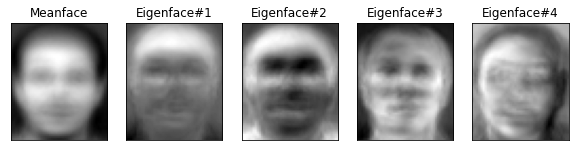

In [95]:
#Plot the first four eigenfaces and mean face
meanface = np.resize(mean,(56,46)).astype(np.uint8)
plt.figure(figsize=(10,10))
plt.subplot(151)
plt.title('Meanface')
plt.imshow(meanface,cmap ='gray')
plt.xticks([])
plt.yticks([])
for i in range(4):
  plt.subplot(1,5,i+2)
  plt.title('Eigenface#%d'%(i+1))
  show_eigenface = np.reshape(u[:,i],(56,46))
#   show_eigenface = np.reshape(eigen_vectors[:,i],(56,46))
  plt.imshow(show_eigenface, cmap = plt.cm.gray)
  plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
  plt.xticks([])
  plt.yticks([])
plt.show()

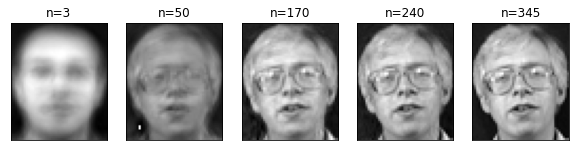

In [96]:
#Reconstruction
weights = np.dot(u.T,x_train) # a1~a360
n = [3,50,170,240,345]
plt.figure(figsize=(10,10))
for idx,i in enumerate(n):
  plt.subplot(1,5,idx+1)
  reconstructed_img = mean + np.dot(weights[:i,p2i1idx], u[:, 0:i].T)
  reconstructed_img = np.resize(reconstructed_img,(56,46)).astype(np.uint8)
  plt.title('n=%d'%(i))
  plt.imshow(reconstructed_img, cmap ='gray')
  plt.xticks([])
  plt.yticks([])
plt.show()

In [97]:
#計算原圖與重建圖的MSE值
target_img = x_train.copy()
for i in n:
  square = 0
  reconstructed_img = np.dot(weights[0:i,p2i1idx], u[:, 0:i].T)
  reconstructed_img = np.resize(reconstructed_img,(56,46)).astype(np.float)
  target_img = np.resize(target_img,(56,46,360)).astype(np.float)
  for j in range(56):
    for k in range(46):
      square += np.square(reconstructed_img[j][k] - target_img[j][k][p2i1idx])
  mean_square_error = round(square / (56*46))
  print('n=%d MSE :'%(i),mean_square_error)

n=3 MSE : 747
n=50 MSE : 237
n=170 MSE : 47
n=240 MSE : 13
n=345 MSE : 0


In [310]:
#K_fold validation
k_fold_face = []
label = []
image_list = os.listdir(dir)
random.shuffle(image_list)
for idx,img_name in enumerate(image_list):
  img_path = os.path.join(dir, img_name)
  if img_name.split('_')[1]=='10.png':
    continue;
  else:
    face = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    face = face.flatten()
    label.append(img_name.split('_')[0])
    k_fold_face.append(face)
k_fold_face = np.array(k_fold_face).astype(np.float).T
label = np.array(label)
print(k_fold_face.shape)
print(label.shape)

(2576, 360)
(360,)


In [311]:
#K_fold cross validation
from collections import Counter
n = [3,50,170]
knn = [1,3,5]
k_fold = 3
num_train = k_fold_face.shape[1]
fold_num = num_train // 3
best_k = 0
best_n = 0
max_acc = 0
for eigennum in n:
  knn1=[]
  knn3=[]
  knn5=[]
  for k in range(k_fold):
    # print('fold %d(n=%d)'%(k,eigennum))
    distance_matrix = np.empty((fold_num,num_train-fold_num))

    x_train_fold = np.concatenate((k_fold_face[:,(k+1)*fold_num:],k_fold_face[:,:k*fold_num]),axis = 1).astype(np.float)
    y_train_fold = np.concatenate((label[(k+1)*fold_num:],label[:k*fold_num]))
    x_val_fold = k_fold_face[:,k*fold_num:(k+1)*fold_num].astype(np.float)
    y_val_fold = label[k*fold_num:(k+1)*fold_num].astype(np.int)

    k_fold_mean = np.mean(x_train_fold, axis = 1).astype(np.float)
    k_fold_mean = k_fold_mean[:,np.newaxis]
    x_train_fold -= k_fold_mean
    x_val_fold -= k_fold_mean
    
    _,lamb, v_fold = np.linalg.svd(x_train_fold)
    v_fold = v_fold.T
    u_fold = np.dot(x_train_fold,v_fold)
    # Normalizing u_fold to ||u_fold||=1
    u_norm = np.linalg.norm(u_fold,axis=0)
    u_fold = u_fold / u_norm

    project_train_fold = u_fold[:,0:eigennum].T.dot(x_train_fold).T # (240,n)
    project_val_fold = u_fold[:,0:eigennum].T.dot(x_val_fold).T   # (120,n)
    for i in range(fold_num):
      for j in range(num_train-fold_num):
        distance_matrix[i][j] = np.sqrt(np.sum(np.square(project_train_fold[j]-project_val_fold[i])))
    min_disidx = np.argsort(distance_matrix,axis=1) #由小到大

    for k_para in knn:
      
      correct = 0.0
      y_pred = np.empty((fold_num)).astype(np.int)
      for i in range(fold_num):
        k_space = []
        k_space.append(y_train_fold[min_disidx[i,:k_para]])
        k_space = np.array(k_space)
        vote = Counter(k_space[0,:k_para])
        count = vote.most_common()
        if k_para == 1:
            y_pred[i] = count[0][0]
        elif k_para == 3:
            if len(count) == 3:
                random_num = np.random.choice(k_para, 1)[0]
                y_pred[i] = count[random_num][0]
            else:
                y_pred[i] = count[0][0]
        elif k_para == 5:
            if len(count) == 5:
                random_num = np.random.choice(k_para, 1)[0]
                y_pred[i] = count[random_num][0]
            if len(count) == 3 and count[0][1] == 2:
                random_num = np.random.choice(2, 1)[0]
                y_pred[i] = count[random_num][0]
            else:
                y_pred[i] = count[0][0]
        if y_pred[i] == y_val_fold[i]:
          correct += 1
      Accurate = (correct / float(fold_num)) *100
      # print('Accurate of k=%d= '%(k_para),Accurate,'%')
      if str(k_para) == '1':
        knn1.append(Accurate)
      elif str(k_para) == '3':
        knn3.append(Accurate)
      else:
        knn5.append(Accurate)
  print('n=%d'%(eigennum))
  print('Accurate of k=1 ',round(np.mean(knn1),2),'%')
  print('Accurate of k=3 ',round(np.mean(knn3),2),'%')
  print('Accurate of k=5 ',round(np.mean(knn5),2),'%')
  if np.mean(knn1) > max_acc:
    best_k = 1
    best_n = eigennum
    max_acc = round(np.mean(knn1),2)
  if np.mean(knn3) > max_acc:
    best_k = 3
    best_n = eigennum
    max_acc = round(np.mean(knn3),2)
  if np.mean(knn5) > max_acc:
    best_k = 5
    best_n = eigennum
    max_acc = round(np.mean(knn5),2)

print('\n\nBest k=',best_k)
print('Best n=',best_n)
print('Best acc=',max_acc,'%')

n=3
Accurate of k=1  66.11 %
Accurate of k=3  57.78 %
Accurate of k=5  52.78 %
n=50
Accurate of k=1  93.33 %
Accurate of k=3  85.0 %
Accurate of k=5  81.11 %
n=170
Accurate of k=1  95.0 %
Accurate of k=3  85.83 %
Accurate of k=5  81.39 %


Best k= 1
Best n= 170
Best acc= 95.0 %


In [312]:
n=best_n
k=best_k
distance_matrix = np.empty((x_test.shape[1],x_train.shape[1]))
project_train = u[:,0:n].T.dot(x_train).T  # (360,n)
project_test = u[:,0:n].T.dot(x_test).T   # (40,n)
for i in range(x_test.shape[1]):
      for j in range(x_train.shape[1]):
        distance_matrix[i][j] = np.sqrt(np.sum(np.square(project_train[j]-project_test[i])))
min_disidx = np.argsort(distance_matrix,axis=1) #由小到大
correct = 0.0
y_pred = np.empty((x_test.shape[1])).astype(np.int)
for i in range(x_test.shape[1]):
  k_space = []
  k_space.append(y_train[min_disidx[i,:k]])
  k_space = np.array(k_space)
  vote = Counter(k_space[0,:k]) 
  count = vote.most_common()    
  y_pred[i] = count[0][0]
  if y_pred[i] == y_test[i]:
    correct += 1
Accurate = round((correct / 40.0) *100,1)

print('Testing acc =',Accurate,'%')

Testing acc = 95.0 %
